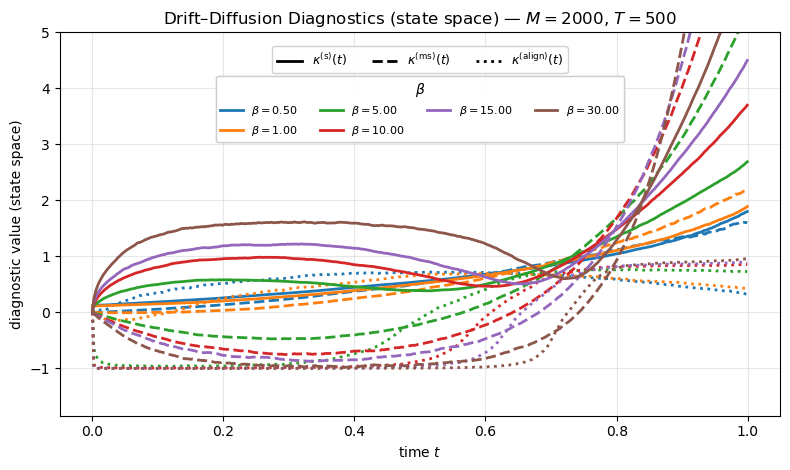

[saved] figs/drift_diff_vs_time_M2000_T500.png


In [2]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# ============================================================
# Drift–Diffusion Balanced Path Diagnostics (STATE SPACE ONLY)
#   • SDE: dX = u*(X,t) dt + dW, unit diffusion, midpoint EM, X0=0
#   • Diagnostics per Section "Drift–Diffusion Balanced Path Diagnostics":
#         κ^(s)(t)     = sqrt( E||u*||^2 / d )
#         κ^(ms)(t)    = 2 E[x·u*] / d
#         κ^(align)(t) = E[ (x·u*) / (||x|| ||u*||) ]
#   • Legends: inside, top-center; y-axis capped at +5 (upper bound only)
#   • Numeric stability: small floors for norms in cosine
# ============================================================

import numpy as np, math, os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

os.makedirs("figs", exist_ok=True)

# ---------- time-series diagnostics for a single β ----------
def diagnostics_time_series_for_beta_state_only(
    b, gmm, M=2000, T=500, seed=12345
):
    """
    Simulate midpoint EM with X0=0 and compute STATE-SPACE diagnostics over time for a single constant β.
    Returns:
      t_mid  : (T,)
      curves : dict with keys 'ks', 'kms', 'kalign' => (T,)
    """
    rng = np.random.default_rng(seed)
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)  # schedule sanity (interior)

    # infer dimension
    try:
        d = int(gmm.d)
    except Exception:
        d = int(np.asarray(gmm.MU).shape[1])

    # init
    X  = np.zeros((M, d), float)  # enforce x(0)=0
    dt = 1.0 / T
    t_mid = (np.arange(T) + 0.5) / T

    # storage
    ks   = np.empty(T, float)   # κ^(s)
    kms  = np.empty(T, float)   # κ^(ms)
    kal  = np.empty(T, float)   # κ^(align)

    EPS_NORM = 1e-12  # guard for cosine

    for n, t in enumerate(t_mid):
        # optimal control u* = b^- ŷ − a^- X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)   # (M,d)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X                       # (M,d)

        # ---------- state-space diagnostics ----------
        u2_mean = float(np.mean(np.sum(u*u, axis=1)))         # E||u||^2
        xu_mean = float(np.mean(np.sum(X*u, axis=1)))         # E[x·u]

        ks[n]  = math.sqrt(max(u2_mean, 0.0) / max(d, 1))     # κ^(s) = sqrt(E||u||^2 / d)
        kms[n] = (2.0 * xu_mean) / float(d)                   # κ^(ms) = 2E[x·u] / d

        # κ^(align): average cosine, safe divisions
        xnorm = np.linalg.norm(X, axis=1) + EPS_NORM
        unorm = np.linalg.norm(u, axis=1) + EPS_NORM
        cos   = np.sum(X*u, axis=1) / (xnorm * unorm)
        kal[n]= float(np.mean(cos))

        # ---------- EM step ----------
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u * dt + dW

    curves = {"ks": ks, "kms": kms, "kalign": kal}
    return t_mid, curves

# ---------------------------- construct three models ----------------------------
models = [
    ("Regular 3×3", regular),
    ("Perturbed A",  pertA),
    ("Perturbed B",  pertB),
]

gmm=pertA

# ---------- run for a set of β and plot ----------
beta_list = [0.5, 1.0, 5.0, 10.0, 15.0, 30.0]
M   = 2000
T   = 500
seed_base = 20240923

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
beta_color = {float(b): colors[i % len(colors)] for i, b in enumerate(beta_list)}

beta_series = {}
for i, b in enumerate(beta_list):
    t_mid, curves = diagnostics_time_series_for_beta_state_only(
        b, gmm, M=M, T=T, seed=seed_base + 17*i
    )
    beta_series[float(b)] = (t_mid, curves)

# ---------- Figure: State-space diagnostics vs time ----------
fig = plt.figure(figsize=(8.0, 4.8))
ax  = fig.gca()

# style legend (top row inside axes)
style_handles = [
    Line2D([0],[0], color="k", lw=2.0, ls="-"),
    Line2D([0],[0], color="k", lw=2.0, ls="--"),
    Line2D([0],[0], color="k", lw=2.0, ls=":"),
]
style_labels = [r"$\kappa^{(\mathrm{s})}(t)$",
                r"$\kappa^{(\mathrm{ms})}(t)$",
                r"$\kappa^{(\mathrm{align})}(t)$"]
leg_styles = ax.legend(style_handles, style_labels,
                       loc="upper center", bbox_to_anchor=(0.5, 0.98),
                       ncol=3, frameon=True, framealpha=0.9, fontsize=9)
ax.add_artist(leg_styles)

# plot curves and build β legend
handles_beta, labels_beta = [], []
for b in beta_list:
    c = beta_color[float(b)]
    t_mid, curves = beta_series[float(b)]
    ax.plot(t_mid, curves["ks"],      lw=2.0, ls="-",  color=c)
    ax.plot(t_mid, curves["kms"],     lw=2.0, ls="--", color=c)
    ax.plot(t_mid, curves["kalign"],  lw=2.0, ls=":",  color=c)
    handles_beta.append(Line2D([0],[0], color=c, lw=2.0))
    labels_beta.append(fr"$\beta={float(b):.2f}$")

leg_beta = ax.legend(handles_beta, labels_beta,
                     loc="upper center", bbox_to_anchor=(0.5, 0.90),
                     ncol=min(4, len(beta_list)), frameon=True, framealpha=0.9,
                     fontsize=8, title=r"$\beta$")
ax.add_artist(leg_beta)

ax.set_xlabel("time $t$")
ax.set_ylabel("diagnostic value (state space)")
ax.set_title(fr"Drift–Diffusion Diagnostics (state space) — $M={M}$, $T={T}$")
ax.grid(True, alpha=0.3)
ax.set_ylim(top=5.0)  # cap upper y-limit at +5 (no lower cap)

fig.tight_layout()
f1 = f"figs/drift_diff_vs_time_M{M}_T{T}.png"
fig.savefig(f1, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {f1}")


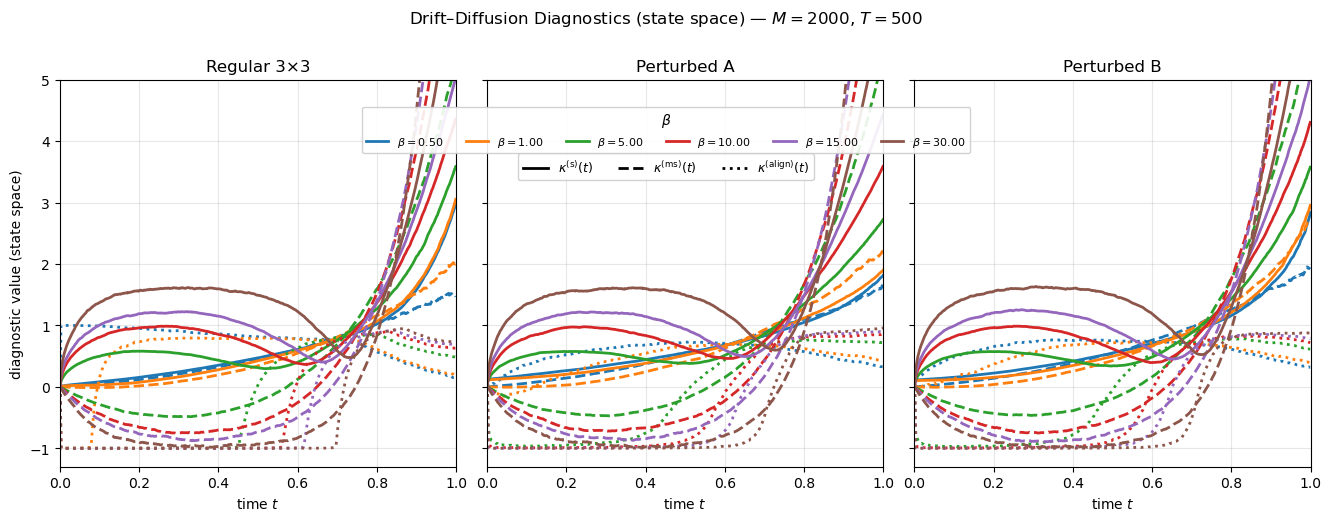

[saved] figs/drift_diff_vs_time_3panel_M2000_T500.png


In [3]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)

# ============================================================
# Drift–Diffusion Balanced Path Diagnostics (STATE SPACE ONLY)
#   • SDE: dX = u*(X,t) dt + dW, unit diffusion, midpoint EM, X0=0
#   • Diagnostics:
#         κ^(s)(t)     = sqrt( E||u*||^2 / d )
#         κ^(ms)(t)    = 2 E[x·u*] / d
#         κ^(align)(t) = E[ (x·u*) / (||x|| ||u*||) ]
#   • Three-panel figure: Regular 3×3, Perturbed A, Perturbed B
#   • Legends stacked at the top (style row, β row)
#   • All panels share the same y-scale (global min..cap@5)
# ============================================================

def diagnostics_time_series_for_beta_state_only(b, gmm, M=2000, T=500, seed=12345):
    """
    Simulate midpoint EM with X0=0 and compute STATE-SPACE diagnostics over time for a single constant β.
    Returns:
      t_mid  : (T,)
      curves : dict with keys 'ks', 'kms', 'kalign' => (T,)
    """
    rng = np.random.default_rng(seed)
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)  # interior sanity

    d = int(getattr(gmm, "d", np.asarray(gmm.MU).shape[1]))
    X  = np.zeros((M, d), float)  # enforce x(0)=0
    dt = 1.0 / T
    t_mid = (np.arange(T) + 0.5) / T

    ks   = np.empty(T, float)   # κ^(s)
    kms  = np.empty(T, float)   # κ^(ms)
    kal  = np.empty(T, float)   # κ^(align)

    EPS_NORM = 1e-12  # guard for cosine

    for n, t in enumerate(t_mid):
        # optimal control u* = b^- ŷ − a^- X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)   # (M,d)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X                       # (M,d)

        # diagnostics
        u2_mean = float(np.mean(np.sum(u*u, axis=1)))         # E||u||^2
        xu_mean = float(np.mean(np.sum(X*u, axis=1)))         # E[x·u]

        ks[n]  = math.sqrt(max(u2_mean, 0.0) / max(d, 1))     # κ^(s)
        kms[n] = (2.0 * xu_mean) / float(d)                   # κ^(ms)

        xnorm = np.linalg.norm(X, axis=1) + EPS_NORM
        unorm = np.linalg.norm(u, axis=1) + EPS_NORM
        cos   = np.sum(X*u, axis=1) / (xnorm * unorm)
        kal[n]= float(np.mean(cos))                           # κ^(align)

        # EM step
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u * dt + dW

    curves = {"ks": ks, "kms": kms, "kalign": kal}
    return t_mid, curves

# ---------------------------- models & parameters ----------------------------
models = [
    ("Regular 3×3", regular),
    ("Perturbed A",  pertA),
    ("Perturbed B",  pertB),
]

beta_list = [0.5, 1.0, 5.0, 10.0, 15.0, 30.0]
M, T = 2000, 500
seed_base = 20240923

# consistent β colors across all panels
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
beta_color = {float(b): colors[i % len(colors)] for i, b in enumerate(beta_list)}

# ---------------------------- run all models, collect for shared scaling ----------------------------
# data_by_model[name][beta] = (t_mid, curves_dict)
data_by_model = {}
global_min = +np.inf
global_max = -np.inf

for m_idx, (name, gmm) in enumerate(models):
    series = {}
    for i, b in enumerate(beta_list):
        t_mid, curves = diagnostics_time_series_for_beta_state_only(
            b, gmm, M=M, T=T, seed=seed_base + 17*i + 1000*m_idx
        )
        series[float(b)] = (t_mid, curves)
        # track global min/max across all diagnostics
        for key in ("ks", "kms", "kalign"):
            vmin = float(np.min(curves[key]))
            vmax = float(np.max(curves[key]))
            if vmin < global_min: global_min = vmin
            if vmax > global_max: global_max = vmax
    data_by_model[name] = series

# cap upper at 5.0 as requested; pad lower a bit for aesthetics
y_top  = min(5.0, global_max if np.isfinite(global_max) else 5.0)
y_bot  = global_min if np.isfinite(global_min) else 0.0
pad    = 0.05 * (y_top - y_bot + 1e-12)
y_lim  = (y_bot - pad, y_top)

# ---------------------------- build 3-panel figure ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(13.2, 4.6), sharex=True, sharey=True, constrained_layout=True)

# top legends (shared)
style_handles = [
    Line2D([0],[0], color="k", lw=2.0, ls="-"),
    Line2D([0],[0], color="k", lw=2.0, ls="--"),
    Line2D([0],[0], color="k", lw=2.0, ls=":"),
]
style_labels = [r"$\kappa^{(\mathrm{s})}(t)$",
                r"$\kappa^{(\mathrm{ms})}(t)$",
                r"$\kappa^{(\mathrm{align})}(t)$"]
leg1 = fig.legend(style_handles, style_labels,
                  loc="upper center", bbox_to_anchor=(0.5, 0.8),
                  ncol=3, frameon=True, framealpha=0.9, fontsize=9)

beta_handles = [Line2D([0],[0], color=beta_color[float(b)], lw=2.0) for b in beta_list]
beta_labels  = [fr"$\beta={float(b):.2f}$" for b in beta_list]
leg2 = fig.legend(beta_handles, beta_labels,
                  loc="upper center", bbox_to_anchor=(0.5, 0.9),
                  ncol=min(6, len(beta_list)), frameon=True, framealpha=0.9, fontsize=8, title=r"$\beta$")

# plot each model in its own panel
for ax, (name, _gmm) in zip(axs, models):
    series = data_by_model[name]
    for b in beta_list:
        c = beta_color[float(b)]
        t_mid, curves = series[float(b)]
        ax.plot(t_mid, curves["ks"],     lw=2.0, ls="-",  color=c)
        ax.plot(t_mid, curves["kms"],    lw=2.0, ls="--", color=c)
        ax.plot(t_mid, curves["kalign"], lw=2.0, ls=":",  color=c)
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_lim)          # same scale for all panels
    ax.set_xlim(0.0, 1.0)

# shared labels
axs[0].set_ylabel("diagnostic value (state space)")
for ax in axs:
    ax.set_xlabel("time $t$")

fig.suptitle(fr"Drift–Diffusion Diagnostics (state space) — $M={M}$, $T={T}$", y=1.10)

fname = f"figs/drift_diff_vs_time_3panel_M{M}_T{T}.png"
fig.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname}")
